In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
from similarity import _ROOT_PATH

root_path = os.path.join( _ROOT_PATH, "Mixed_IE/further_processed/statistic/")
file_list = ["wikitabletext", "wikibio", "e2e", "rotowire", "CPL"]
name_list = ["Wikitabletext", "Wikibio", "E2E", "Rotowire", "CPL"]
all_lens = [20059, 827749, 1290, 9486, 15025]
metric = ["Sum", "Average", "Max", "Median", "Trimmed_Sum", "Trimmed_Average", "Trimmed_Max"]
file_name = "embedding_all.pkl"
metric_y = ["Sum", "Mean", "Max", "Median", "Trim Sum", "Trim Mean", "Trim Max"]
metric_x = ["Group Max", "Group Mean", "Group Median"]
colors = ["r", "b", "g", "c", "m", "y", "k"]

num_parts = 200

In [2]:
def grid_plot_all_set( all_containers, row, col):
    types = 5
    fig, axs = plt.subplots(types, 1, figsize=(7, 7), constrained_layout=True)
    datas = []
    for i in range( len(all_containers) ):
        datas.append( all_containers[i][row][col] )
    
    for i in range(types):  
        ax = axs[i]  
        values = np.array(datas[i])
        
        # 绘制折线图    
        ax.plot(range(len(values)), values, marker='o', markersize=1, linewidth=0.5, color=colors[i])  
        
        # 转换X轴为百分比  
        percentages = np.linspace(0, 100, len(values))  # 创建一个从0%到100%的等差数组  
        
        # 找到最高点（最大值)  
        start_point = len(values)//100  
        max_index = np.argmax(values[start_point:]) + start_point

        
        max_value = values[max_index]  
        
        # 在最高点处画一条横线(从百分之一位开始找)
        ax.axhline(y=max_value, color='k', linestyle='--', label='Max Value Line', linewidth=0.5)  
        # 绘制交点（即最大值点）的高亮显示  
        ax.scatter(max_index, max_value, color='k', s=10)  # 高亮显示交点
        '''
        cross_points = np.where(values >= max_value)[0]
        if len(cross_points)==1:
            leftmost_cross_index = cross_points[-1]
        else:
            leftmost_cross_index = cross_points[-2]
        ax.axvline(x=leftmost_cross_index, color='k', linestyle='--', label='Max Value X', linewidth=0.5) 
        ax.annotate(f'{leftmost_cross_index}',   
                 xy=(leftmost_cross_index, 0),   
                 xytext=(0, -5),  # 文本位置稍微向下偏移  
                 textcoords="offset points",  
                 ha='center', va='top',  
                 arrowprops=dict(facecolor='black', arrowstyle='->')) 
        '''
        # 设置X轴的刻度为百分比  
        ax.set_xticks(np.linspace(0, len(values)-1, 10).astype(int))  # 例如，只显示10个刻度  
        ax.set_xticklabels(['{:.0f}'.format(x*100/len(values)) for x in ax.get_xticks()])  # 将刻度标签转换为百分比  
        
        if i != types-1:  
            ax.set_xticks([])  # 如果你不想在每个子图上显示X轴刻度，可以注释掉上面的两行并取消注释这行  
        
        # 设置子图的标题和标签
        _shape = "L-Shape" if i < 3 else "V-Shape"
        ax.set_title(f"Results of {name_list[i]} ({all_lens[i]}), {_shape}")  
        if i == types-1:  # 通常，你可能想在最后一个子图上设置X轴标签  
            ax.set_xlabel(f"Percentiles")  
        ax.set_ylabel(f"Similarity")
    
    fig.suptitle(f'Statistic Results of {metric_y[row]} Similarity with {metric_x[col]}', fontsize=14)  
    plt.tight_layout()  # 这可以帮助避免子图之间的重叠
    plt.savefig('Similarity.pdf', dpi=600, bbox_inches='tight',format="pdf")
    plt.show()

def grid_values( floats_lists, num_parts, index ):
    #num_parts = 200
    #floats_lists = lists
    container = []
    print(f"Process {name_list[index]}")
    for i in range(len(floats_lists)):
        if index==3:
            if i!=0 and i!=2:
                container.append( [] ) 
                continue
        floats_list = floats_lists[i]
        spans = len(floats_list)// num_parts
        parts = [floats_list[i:i + spans] for i in range(0, len(floats_list), spans)]
        # 计算每份的平均值
        averages = [np.mean(part) for part in parts]
        
        # 计算每份的最大值
        maxs = [np.max(part) for part in parts]
        # 计算每份的中位值
        medians = [np.median(part) for part in parts]
        def norm( data_list ):
            min_value = min(data_list)  
            max_value = max(data_list)  
            normalized_averages = [(value - min_value) / (max_value - min_value) for value in data_list]

        container.append( [maxs, averages, medians] )     # # 7*3*num_parts
    return container, len(floats_lists[0])
    

def read_file( index ):
    dic_path = os.path.join(root_path, file_list[index] )
    with open( os.path.join(dic_path, "embedding_all.pkl"), 'rb') as f:  
        data = pickle.load( f)
    ret_list = [ [] for _ in range(7)]
    flag = 0
    if index == 3:
        for key in data:
            ret_list[0].append( data[key][0] )
            ret_list[2].append( data[key][1] )
    else:
        for key in data:
            ret_list[0].append( data[key][0] )
            ret_list[1].append( data[key][1] )
            ret_list[2].append( data[key][2] )
            if str( data[key][3].device ) !='cpu':
                flag = 1
                data[key][3] = data[key][3].to('cpu')
            ret_list[3].append( data[key][3] )
            ret_list[4].append( data[key][4] )
            ret_list[5].append( data[key][5] )
            ret_list[6].append( data[key][6] )
        if flag==1:
            print("ddd")
            with open( os.path.join(dic_path, "embedding_all.pkl"), 'wb') as f:  
                pickle.dump(data,  f)
    return ret_list

In [3]:
all_containers = []
all_lens = []
for index in range(5):
    floats_lists = read_file(index)
    lists, lens = grid_values( floats_lists, num_parts, index )
    all_containers.append( lists )
    all_lens.append( lens )

FileNotFoundError: [Errno 2] No such file or directory: '/data/jiangpeiwen2/workspace/TKGT/Mixed_IE/further_processed/statistic/rotowire/embedding_all.pkl'

findfont: Generic family 'sans-serif' not found because none of the following families were found: HeiTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: HeiTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: HeiTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: HeiTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: HeiTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: HeiTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: HeiTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: HeiTi
findfont: Generic family 'sans-serif' not found because none of the following families were found: HeiTi
findfont: Generic family 'sans-serif' not found because

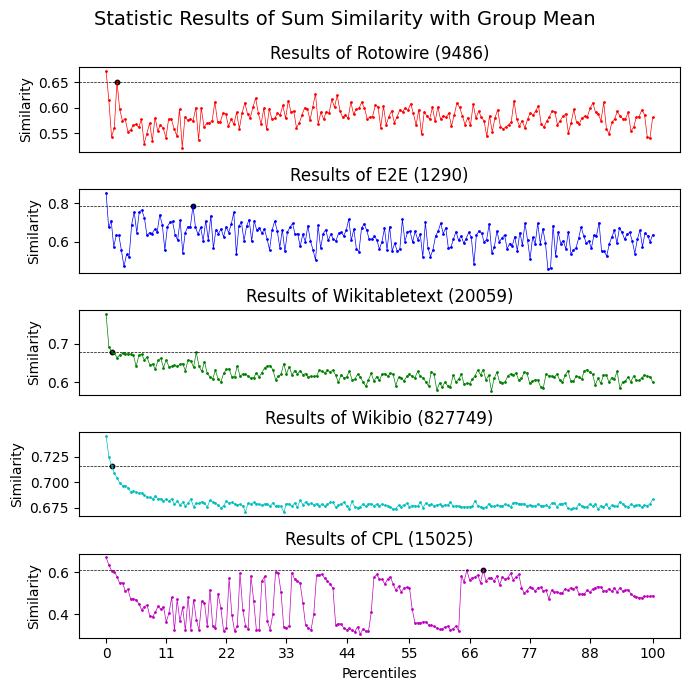

In [15]:
row = 0
col = 1
grid_plot_all_set( all_containers, row, col)

/tmp/ipykernel_2881848/2313605165.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # 这可以帮助避免子图之间的重叠


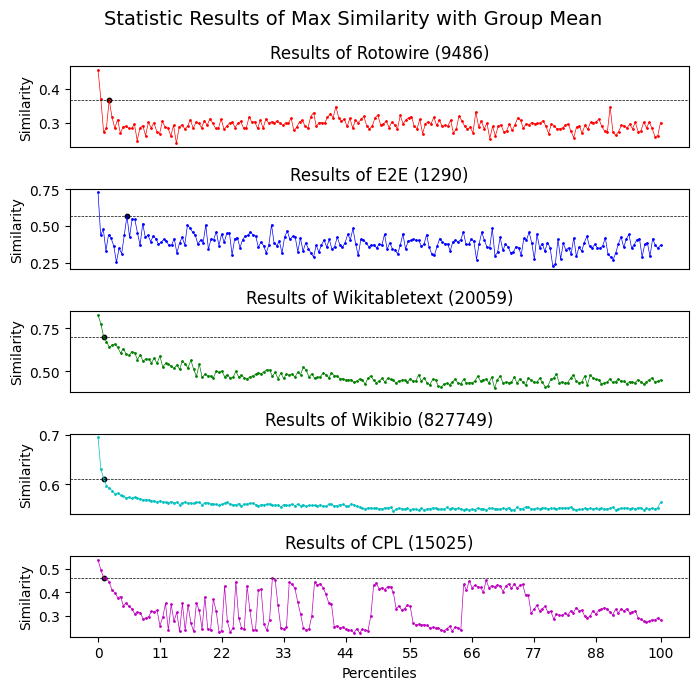

In [79]:
row = 2
col = 1
grid_plot_all_set( all_containers, row, col)